In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
from sklearn.ensemble import IsolationForest


##### Read Data

Dataset consists of AWS EC2 CPU utilization values.

- Columns: Timestamp, Value
- Number of Rows: 4032

Data Source: https://github.com/numenta/NAB/blob/master/data/realAWSCloudwatch/ec2_cpu_utilization_24ae8d.csv

In [229]:
data = pd.read_csv('./ec2_cpu_utilization_24ae8d.csv')

#### Descriptive Statistics

- Calculate mean, median, max, min, and kurtosis values. 
- Plot CPU utilization distribution in the form of a density plot.

Mean CPU Utilization: 0.1263030753968254
Median CPU Utilization: 0.134
Maximum CPU Utilization: 2.344
Minimum CPU Utilization: 0.066
Number of values >=0.1 and/or <= -0.06 from Median CPU Utilization: 931 (23.09%)
Sample Excess Kurtosis: 229.92534587955123


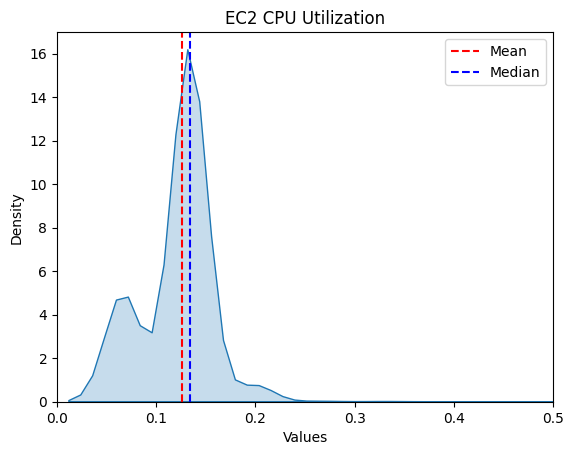

In [230]:
# Calculate the mean of the 'column_name' column
mean_value = data['value'].mean()
print("Mean CPU Utilization:", mean_value)
# Calculate the median of the 'column_name' column
median_value = data['value'].median()
print("Median CPU Utilization:", median_value)

# Calculate the maximum value in the 'column_name' column
max_value = data['value'].max()
print("Maximum CPU Utilization:", max_value)
# Calculate the minimum value in the 'column_name' column
min_value = data['value'].min()
print("Minimum CPU Utilization:", min_value)

# Check for skew
data['mean_value_diff'] = data['value'] - mean_value
data['median_value_diff'] = data['value'] - median_value
print("Number of values >=0.1 and/or <= -0.06 from Median CPU Utilization:", len(data[(data['median_value_diff'] >= 0.1) | (data['median_value_diff'] <= -0.06)]), f"({round((len(data[(data['median_value_diff'] >= 0.1) | (data['median_value_diff'] <= -0.06)])/len(data))*100, 2)}%)")

# Calculate the kurtosis of the data set
data_kurtosis = kurtosis(data['value'], fisher=True)
print("Sample Excess Kurtosis:", data_kurtosis)

# Generate a density plot
sns.kdeplot(data=data['value'], fill=True)
# Add vertical lines for mean and median
plt.xlim(0, 0.5)
plt.axvline(mean_value, color='red', linestyle='--', label='Mean')
plt.axvline(median_value, color='blue', linestyle='--', label='Median')
# Add labels and title
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('EC2 CPU Utilization')
# Show the legend with line labels
plt.legend()
# Show the plot
plt.show()


#### Unsupervised Anomaly Detection using Isolation Forest

In [261]:
#Isolate CPU Utilization values for anomaly detection
output = np.array([data['mean_value_diff']])
output = output.reshape(-1, 1)

In [282]:
# Perform anomaly detection using Isolation Forest
isolation_forest = IsolationForest(n_estimators=4032, contamination=0.05, random_state=42)
isolation_forest.fit(output)

# Predict anomalies
predictions = isolation_forest.predict(output)

In [283]:
# Recode anomalous prediction values
predictions = [1 if pred == -1 else 0 for pred in predictions]

# View Isolation Forest Predictions
data['predictions'] = predictions
print(data[data['predictions']== 1])

# Separate data based on the 'prediction' value
prediction_0 = data[data['predictions'] == 0]
prediction_1 = data[data['predictions'] == 1]

                timestamp  value  mean_value_diff  median_value_diff  \
13    2014-02-14 15:35:00  0.202         0.075697              0.068   
41    2014-02-14 17:55:00  0.202         0.075697              0.068   
61    2014-02-14 19:35:00  0.200         0.073697              0.066   
70    2014-02-14 20:20:00  0.200         0.073697              0.066   
113   2014-02-14 23:55:00  0.200         0.073697              0.066   
...                   ...    ...              ...                ...   
3875  2014-02-28 01:25:00  0.200         0.073697              0.066   
3898  2014-02-28 03:20:00  1.600         1.473697              1.466   
3969  2014-02-28 09:15:00  0.200         0.073697              0.066   
3977  2014-02-28 09:55:00  0.202         0.075697              0.068   
3997  2014-02-28 11:35:00  0.202         0.075697              0.068   

      predictions  
13              1  
41              1  
61              1  
70              1  
113             1  
...           .

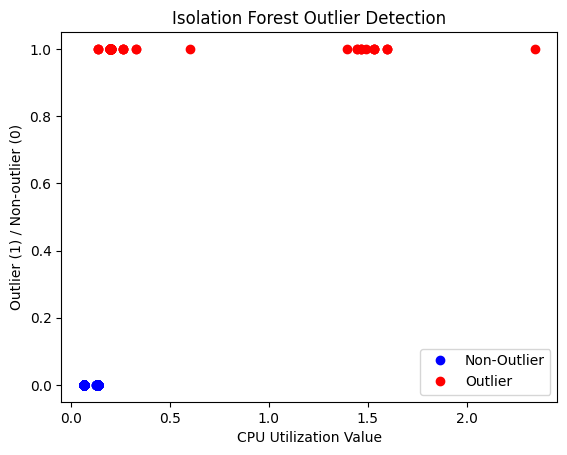

In [284]:
# Visualize prediction results
plt.plot(prediction_0['value'], prediction_0['predictions'], marker='o', linestyle='', color='blue', label='Non-Outlier')
plt.plot(prediction_1['value'], prediction_1['predictions'], marker='o', linestyle='', color='red', label='Outlier')
plt.xlabel('CPU Utilization Value')
plt.ylabel('Outlier (1) / Non-outlier (0)')
plt.title('Isolation Forest Outlier Detection')
plt.legend()
plt.show()

From prediction results we can see Isolation Forest model with a contamination rate of 0.05 performed well at detecting anomalous utilization values greater than the mean/median. 162 datapoints were predicted to be anomalous (~4% of 4032 data points). However, it is missing the second group of outliers (i.e., when utilization < 0.06). This limitation in model performance could be due to insufficient data. 